### Modelo básico. Decision Tree

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import SelectKBest, f_classif

In [3]:
df = pd.read_csv("../data/processed/processed_new_columns.csv", index_col=0)

In [4]:
df.head(5)

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,...,explicit,artists_frequency,version_type,base_name,version_Live,version_Original,version_Remaster,version_Remix,version_type_encoded,decade
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,...,0,51,Original,!Que Vida! - Mono Version,0,1,0,0,1,1960
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,...,0,218,Original,"""40""",0,1,0,0,1,1980
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,...,0,218,Live,"""40"" -",1,0,0,0,0,1980
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,0,218,Remaster,"""40"" - 2008",0,0,1,0,2,1980
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,0,218,Remaster,"""40"" - 2008",0,0,1,0,2,1980


Comenzamos tomando la decisión de centrarnos en las décadas desde 1950 hasta la de 2010, ambas incluidas. Esta decisión se fundamenta en dos motivos principales:

- Motivo estadístico: El análisis descriptivo previo nos ha mostrado una descompensación de datos en función de las décadas. El periodo escogido sí tiene una representación equilibrada.
- Motivo de negocio: Si el objetivo es que personas de edad avanzada puedan escuchar canciones de ahora que suenan a décadas pasadas, esas en las que ellos eran más jóvenes y descubrían nueva música, contar con décadas anteriores a los 50 no tendría mucho sentido por el propio perfil (edad) de los usuarios.

In [5]:
#Incluimos solo canciones entre las décadas de 1950 y 2010
df = df[(df['decade'] >= 1950) & (df['decade'] <= 2010)]

In [6]:
#Nueva variable target para poder utilizar en el modelo XGBoost
decade_mapping = {}
for idx, decade in enumerate(sorted(df['decade'].unique())):
    decade_mapping[decade] = idx
df['decade_label'] = df['decade'].map(decade_mapping)

In [7]:
df.head(5)

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,...,artists_frequency,version_type,base_name,version_Live,version_Original,version_Remaster,version_Remix,version_type_encoded,decade,decade_label
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,...,51,Original,!Que Vida! - Mono Version,0,1,0,0,1,1960,1
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,...,218,Original,"""40""",0,1,0,0,1,1980,3
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,...,218,Live,"""40"" -",1,0,0,0,0,1980,3
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,218,Remaster,"""40"" - 2008",0,0,1,0,2,1980,3
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,218,Remaster,"""40"" - 2008",0,0,1,0,2,1980,3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139848 entries, 0 to 169906
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    139848 non-null  object 
 1   name                  139848 non-null  object 
 2   artists               139848 non-null  object 
 3   duration_ms           139848 non-null  int64  
 4   release_date          139848 non-null  object 
 5   year                  139848 non-null  int64  
 6   acousticness          139848 non-null  float64
 7   danceability          139848 non-null  float64
 8   energy                139848 non-null  float64
 9   instrumentalness      139848 non-null  float64
 10  liveness              139848 non-null  float64
 11  loudness              139848 non-null  float64
 12  speechiness           139848 non-null  float64
 13  tempo                 139848 non-null  float64
 14  valence               139848 non-null  float64
 15  mode 

In [9]:
df.columns

Index(['id', 'name', 'artists', 'duration_ms', 'release_date', 'year',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity', 'explicit', 'artists_frequency', 'version_type',
       'base_name', 'version_Live', 'version_Original', 'version_Remaster',
       'version_Remix', 'version_type_encoded', 'decade', 'decade_label'],
      dtype='object')

In [10]:
X = df[['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness',
      'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
      'key', 'popularity', 'explicit', 'version_type_encoded']]
y = df['decade_label']

In [11]:
#Dividimos en conjuntos para entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [12]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(139848, 15)
(27969, 15)
(111879, 15)
(27969,)
(111879,)


In [13]:
model_1 = XGBClassifier(n_estimators=100, random_state=42)

In [14]:
#Entrenamiento
model_1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [15]:
#Evaluación
y_pred_1 = model_1.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred_1)
precision_1 = precision_score(y_test, y_pred_1, average='macro')
recall_1 = recall_score(y_test, y_pred_1, average='macro')
f1_1 = f1_score(y_test, y_pred_1, average='macro')

In [16]:
print("Accuracy del modelo RandomForestClassifier:", accuracy_1)
print("Precisión (Precision):", precision_1)
print("Sensibilidad (Recall):", recall_1)
print("F1-Score:", f1_1)

Accuracy del modelo RandomForestClassifier: 0.537848926071917
Precisión (Precision): 0.5381511703810292
Sensibilidad (Recall): 0.5378709525211499
F1-Score: 0.5368291275207956


<mark>**Observación:**</mark> Mejora significativa: El modelo de Random Forest está funcionando mejor que el Decision Tree en todos los aspectos evaluados. Esto es consistente con la capacidad del Random Forest de capturar patrones complejos y reducir el sobreajuste en comparación con un solo árbol de decisión. No obstante, hay mucho margen de mejora.

In [17]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_1))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     16051
           1       0.53      0.55      0.54     15958
           2       0.43      0.43      0.43     15962
           3       0.48      0.42      0.45     16011
           4       0.41      0.37      0.38     15996
           5       0.45      0.52      0.48     15989
           6       0.66      0.72      0.69     15912

    accuracy                           0.54    111879
   macro avg       0.54      0.54      0.54    111879
weighted avg       0.54      0.54      0.54    111879



In [18]:
#Matriz de confusión
print("Matriz de confusión:")
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)
print(conf_matrix_1)

Matriz de confusión:
[[12047  3070   414   142   197   139    42]
 [ 2440  8811  2693   674   677   479   184]
 [  179  2509  6900  3136  1693  1108   437]
 [  104  1130  3359  6803  2798  1410   407]
 [   53   611  1817  2760  5841  3673  1241]
 [   18   283   563   564  2583  8245  3733]
 [    2    73   169   108   604  3429 11527]]


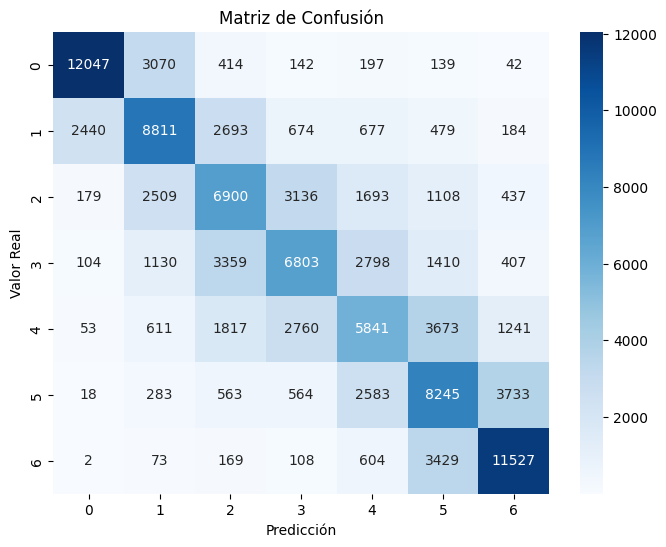

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

<mark>**Observaciones:**</mark>

- **Clase dominante (esquinas):** En las décadas más recientes y antiguas, como en las esquinas de la matriz (la primera y última filas y columnas), se puede ver que el modelo tiene un número notable de clasificaciones correctas, pero también muestra errores considerables.
- **Confusión entre décadas cercanas.** El modelo tiende a confundir décadas consecutivas. Por ejemplo, en las filas centrales (correspondientes a décadas como los 70s, 80s y 90s), hay un número significativo de errores entre décadas vecinas. Esto puede indicar que las características en el estilo y producción musical de las canciones de esas décadas son similares, haciendo difícil la distinción.
- **Desempeño general aceptable:** Aunque hay errores, el modelo básico está funcionando razonablemente bien, clasificando correctamente una gran cantidad de canciones en sus respectivas décadas.

In [20]:
#ROC-AUC multiclase (aunque es una métrica más favorable para modelos de clasificación binaria)
y_test_binarized_1 = label_binarize(y_test, classes=np.unique(y))
y_pred_proba_1 = model_1.predict_proba(X_test)
auc_score_1 = roc_auc_score(y_test_binarized_1, y_pred_proba_1, average='macro')
print("ROC-AUC Score (macro-average):", auc_score_1)

ROC-AUC Score (macro-average): 0.8883176125608602


En un caso multiclase como este, se evalúa la capacidad del modelo para predecir correctamente cada clase en comparación con las demás.

### Optimización 1: Feature importance

In [21]:
feature_importances = model_1.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [22]:
importance_df

,Feature,Importance
12,popularity,0.381099
13,explicit,0.150062
6,loudness,0.056936
1,acousticness,0.055457
14,version_type_encoded,0.043234
0,duration_ms,0.042487
9,valence,0.036289
3,energy,0.034643
4,instrumentalness,0.034506
2,danceability,0.034461


In [23]:
X_reduc = df[['duration_ms', 'acousticness', 'danceability', 'energy', 
              'loudness', 'speechiness', 'valence', 'popularity', 
              'instrumentalness', 'explicit', 'version_type_encoded']]

In [24]:
#Dividimos en conjuntos para entrenamiento y pruebas
X_train_reduc, X_test_reduc, y_train, y_test = train_test_split(X_reduc, y, train_size=0.2, random_state=42)

In [25]:
print(X.shape)
print(X_train_reduc.shape)
print(X_test_reduc.shape)
print(y_train.shape)
print(y_test.shape)

(139848, 15)
(27969, 11)
(111879, 11)
(27969,)
(111879,)


In [26]:
model_2 = XGBClassifier(n_estimators=100, random_state=42)

In [27]:
#Entrenamiento
model_2.fit(X_train_reduc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
#Evaluación
y_pred_2 = model_2.predict(X_test_reduc)
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2, average='macro')
recall_2 = recall_score(y_test, y_pred_2, average='macro')
f1_2 = f1_score(y_test, y_pred_2, average='macro')

In [29]:
print("Accuracy del modelo RandomForest:", accuracy_2)
print("Precisión (Precision):", precision_2)
print("Sensibilidad (Recall):", recall_2)
print("F1-Score:", f1_2)

Accuracy del modelo RandomForest: 0.5352121488393711
Precisión (Precision): 0.5356352516335574
Sensibilidad (Recall): 0.5352285543052606
F1-Score: 0.5341928610102761


<mark>**Conclusiones:**</mark> 

- Haciendo una selección de variables (feature importance > 5) el modelo empeora mínimamente, lo que confirma que estas características tienen una importancia mínima en la predicción de la década.

- La ligera caída en las métricas sugiere que las características eliminadas (key, explicit, mode, version_type_encoded) eran redundantes o no contribuían significativamente a la predicción.

- La reducción en la complejidad del modelo puede ser beneficiosa en términos de eficiencia y generalización, aunque no se logró una mejora en el rendimiento.



### Optimización 2: SelectKBest

In [30]:
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

In [31]:
print(f"Características seleccionadas con SelectKBest (top {k}):")
print(selected_features)

Características seleccionadas con SelectKBest (top 10):
Index(['duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'valence', 'popularity',
       'explicit'],
      dtype='object')


In [32]:
X_train_k, X_test_k, y_train, y_test = train_test_split(X_new, y, train_size=0.2, random_state=42)

In [33]:
print(X.shape)
print(X_train_k.shape)
print(X_test_k.shape)
print(y_train.shape)
print(y_test.shape)

(139848, 15)
(27969, 10)
(111879, 10)
(27969,)
(111879,)


In [34]:
model_3 = XGBClassifier(n_estimators=100, random_state=42)

In [35]:
#Entrenamiento
model_3.fit(X_train_k, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [36]:
#Evaluación
y_pred_3 = model_3.predict(X_test_k)
accuracy_3 = accuracy_score(y_test, y_pred_3)
precision_3 = precision_score(y_test, y_pred_3, average='macro')
recall_3 = recall_score(y_test, y_pred_3, average='macro')
f1_3 = f1_score(y_test, y_pred_3, average='macro')

In [37]:
print("Accuracy del modelo RandomForestClassifier:", accuracy_3)
print("Precisión (Precision):", precision_3)
print("Sensibilidad (Recall):", recall_3)
print("F1-Score:", f1_3)

Accuracy del modelo RandomForestClassifier: 0.529715138676606
Precisión (Precision): 0.5301314006658918
Sensibilidad (Recall): 0.5297386441937098
F1-Score: 0.5285026223116844


<mark>**Conclusión:**</mark> SelectKBest no mejoró significativamente el modelo. Esto sugiere que el modelo ya estaba utilizando las características más relevantes de manera efectiva.



### Optimización 3: Hiperparametrización

In [38]:
#Configuración de hiperparámetros para RandomForest
param_grid = {
    'n_estimators': [50, 100],  # Reducción en el número de estimadores para disminuir el tiempo de entrenamiento
    'max_depth': [3, 5],        # Profundidades más pequeñas para menor complejidad
    'learning_rate': [0.05, 0.1],  # Tasa de aprendizaje ajustada
    'subsample': [0.7, 0.8]     # Subconjuntos de datos para mejorar la generalización
}

In [39]:
grid_search = GridSearchCV(XGBClassifier(n_estimators=100, random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_k, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.7; total time=   2.1s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.7; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.7; total time=   2.7s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.9s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   1.4s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.2s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.2s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.0s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsam

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.7, 0.8]},
             scoring='accuracy', verbose=2)

In [40]:
# Mostrar los mejores parámetros encontrados
grid_best_params = grid_search.best_params_
print("Mejores hiperparámetros:", grid_best_params)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [41]:
#Evaluación del modelo
best_model = grid_search.best_estimator_
y_pred_4 = best_model.predict(X_test_k)
accuracy_4 = accuracy_score(y_test, y_pred_4)
precision_4 = precision_score(y_test, y_pred_4, average='macro')
recall_4 = recall_score(y_test, y_pred_4, average='macro')
f1_4 = f1_score(y_test, y_pred_4, average='macro')

In [42]:
print("Accuracy del modelo Decision Tree:", accuracy_4)
print("Precisión (Precision):", precision_4)
print("Sensibilidad (Recall):", recall_4)
print("F1-Score:", f1_4)

Accuracy del modelo Decision Tree: 0.53495294023007
Precisión (Precision): 0.5357610193475044
Sensibilidad (Recall): 0.5349909680074453
F1-Score: 0.5323676610394099


<mark>**Conclusión:**</mark> La hiperparametrización ha mejorado el modelo de forma significativa, mostrando que ajustar la profundidad a 10, el mínimo de muestras por hoja a 2 y los nodos mínimos a 2 mejora la capacidad de generalización. No obstante, el rendimiento sigue siendo moderado y deberemos probar con otro modelos. 

### Guardar modelo

In [48]:
import pickle

with open('basicmodel.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [49]:
pickle.dump(best_model, open('basicmodel.pkl', 'wb'))

In [50]:
with open('basicmodel.pkl', 'rb') as f:
    modelo_importado = pickle.load(f)

modelo_importado

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [51]:
modelo_importado.predict(X_test_k)

array([3, 3, 2, ..., 2, 2, 6])